In [100]:
import os
import mlflow
import numpy as np
import pandas as pd

from math import sqrt
from joblib import delayed
from joblib import Parallel

from warnings import catch_warnings
from warnings import filterwarnings
from multiprocessing import cpu_count
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib import pyplot
import matplotlib.dates as mdates

from pathlib import Path
from functools import reduce
from datetime import datetime

from prophet import Prophet
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from regressors import stats
from mlxtend.feature_selection import SequentialFeatureSelector as sfs



In [43]:
#Load GDP data 
df_GDP = pd.read_csv('./1.1.csv', converters={'ags2': str, 'ags5': str} )
# fix ags5 missing 0 
df_GDP['ags5'] = np.where(df_GDP.ags5.str.len() == 4, '0' + df_GDP['ags5'], df_GDP['ags5'])
#df_GDP.set_index('ags5', drop=True, inplace=True)
df_GDP = df_GDP.drop("Unnamed: 0", axis=1)
df_GDP = df_GDP.rename(columns={'time_stamp': 'year', 'value':'gdp'})
df_GDP['year'] = pd.to_datetime(df_GDP['year'], format = '%Y')
df_GDP['year'] = df_GDP['year'].dt.year
df_GDP

,ags5,year,gdp
0,01001,2008,3105.912
1,01001,2009,2993.960
2,01001,2010,3013.761
3,01001,2011,3047.700
4,01001,2012,3124.752
...,...,...,...
4406,16077,2014,1869.001
4407,16077,2015,1849.958
4408,16077,2016,1928.277
4409,16077,2017,1972.319


In [44]:
#Load UR data 
df_UR = pd.read_csv('./../../final_dfs/for_modeling/df_final_date_long_2007.csv', converters={'ags2': str, 'ags5': str} )
# fix ags5 missing 0 
df_UR['ags5'] = np.where(df_UR.ags5.str.len() == 4, '0' + df_UR['ags5'], df_UR['ags5'])
#df_UR.set_index('ags5', drop=True, inplace=True)
df_UR = df_UR.drop("Unnamed: 0", axis=1)
df_UR['date'] = pd.to_datetime(df_UR['date'], format = '%Y-%m-%d')
df_UR = df_UR[df_UR['variable'] == 'unemployment_rate']
df_UR = df_UR.rename(columns={'value': 'unemployment_rate'})
df_UR = df_UR[['ags5','ags2', 'date', 'unemployment_rate']]
df_UR['year'] = df_UR['date'].dt.year
df_UR

,ags5,ags2,date,unemployment_rate,year
532211,01001,1,2007-05-01,12.7,2007
532212,01001,1,2007-06-01,12.2,2007
532213,01001,1,2007-07-01,12.5,2007
532214,01001,1,2007-08-01,12.3,2007
532215,01001,1,2007-09-01,11.7,2007
...,...,...,...,...,...
599975,16077,16,2021-01-01,7.3,2021
599976,16077,16,2021-02-01,7.3,2021
599977,16077,16,2021-03-01,7.2,2021
599978,16077,16,2021-04-01,6.9,2021


In [46]:
df_full = pd.merge(df_GDP, df_UR, left_on=['ags5','year'], right_on=['ags5','year'])

In [77]:
df_full

,ags5,year,gdp,ags2,date,unemployment_rate
0,01001,2008,3105.912,1,2008-01-01,11.6
1,01001,2008,3105.912,1,2008-02-01,11.5
2,01001,2008,3105.912,1,2008-03-01,11.4
3,01001,2008,3105.912,1,2008-04-01,11.4
4,01001,2008,3105.912,1,2008-05-01,11.4
...,...,...,...,...,...,...
52927,16077,2018,2017.299,16,2018-08-01,7.4
52928,16077,2018,2017.299,16,2018-09-01,7.3
52929,16077,2018,2017.299,16,2018-10-01,7.3
52930,16077,2018,2017.299,16,2018-11-01,7.3


In [87]:
df_full_mean_UR = df_full.groupby(['ags5','ags2','year']).mean()
df_full_mean_UR

gdp  unemployment_rate
ags5  ags2 year                             
01001 1    2008  3105.912          11.408333
           2009  2993.960          12.883333
           2010  3013.761          12.700000
           2011  3047.700          11.858333
           2012  3124.752          11.358333
...                   ...                ...
16077 16   2014  1869.001          10.941667
           2015  1849.958          10.391667
           2016  1928.277           9.191667
           2017  1972.319           8.583333
           2018  2017.299           7.725000

[4411 rows x 2 columns]

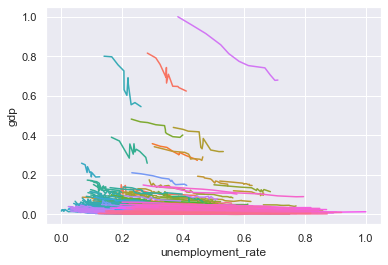

In [99]:
g = sns.lineplot(data=df_full_mean_UR, x="unemployment_rate", y="gdp", hue="ags5")
g.legend_.remove()

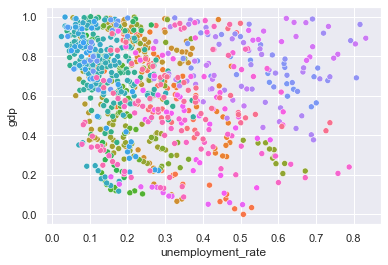

In [97]:
df_full_small = df_full[df_full['gdp'] < 2500]
df_full_mean_UR_small = df_full_small.groupby(['ags5','ags2','year']).mean()
df_full_mean_UR_small
g = sns.scatterplot(data=df_full_mean_UR_small, x="unemployment_rate", y="gdp", hue="ags5")
g.legend_.remove()

In [65]:
sample_args = random.sample(list(set(df_full['ags5'])), 30)
df_sample = df_full[df_full['ags5'].isin(sample_args)]
df_sample_mean_UU = df_sample.groupby(['ags5','ags2','year']).mean()

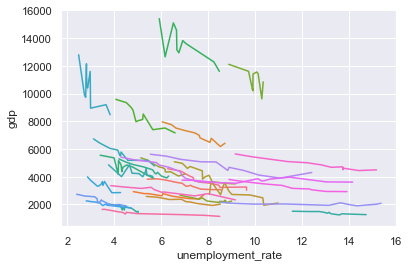

In [66]:
g = sns.lineplot(data=df_sample_mean_UU, x="unemployment_rate", y="gdp",  hue="ags5")
g.legend_.remove()

In [98]:
scaler = MinMaxScaler()
df_full_mean_UR[['gdp','unemployment_rate']] = scaler.fit_transform(df_full_mean_UR[['gdp','unemployment_rate']])
df_full_mean_UR

gdp  unemployment_rate
ags5  ags2 year                             
01001 1    2008  0.015127           0.565137
           2009  0.014353           0.647195
           2010  0.014490           0.636996
           2011  0.014725           0.590172
           2012  0.015258           0.562355
...                   ...                ...
16077 16   2014  0.006575           0.539175
           2015  0.006443           0.508577
           2016  0.006985           0.441817
           2017  0.007289           0.407974
           2018  0.007600           0.360223

[4411 rows x 2 columns]

In [110]:
X = df_full.drop(['year','gdp'], axis=1)
Y = df_full['gdp']
X

,ags5,ags2,date,unemployment_rate
0,01001,1,2008-01-01,11.6
1,01001,1,2008-02-01,11.5
2,01001,1,2008-03-01,11.4
3,01001,1,2008-04-01,11.4
4,01001,1,2008-05-01,11.4
...,...,...,...,...
52927,16077,16,2018-08-01,7.4
52928,16077,16,2018-09-01,7.3
52929,16077,16,2018-10-01,7.3
52930,16077,16,2018-11-01,7.3


In [111]:
X['date'] = X['date'].astype(str)
#X['ags2'] = X['ags2'].astype(str)
X['ags5'] = X['ags5'].astype(str)
X = pd.get_dummies(data=X, drop_first=True)

In [112]:
regr = LinearRegression()
regr.fit(X, Y, sample_weight=None)

LinearRegression()

In [113]:
stats.summary(regr, X, Y, X.columns)

LinAlgError: Singular matrix